# Detailed Analysis: Trump Speech Prediction Markets

This notebook analyzes recurrence of specific words in Donald Trump's speeches to predict outcomes for Polymarket events. 

## Targets
1.  **"Please" / "Thank"** (Threshold: 20+)
2.  **"Jew" / "Jewish"** (Threshold: 10+)
3.  **"Job" / "Jobs"** (Threshold: 7+)
4.  **"Biden" / "Obama"** (Distribution Analysis)

## Subsets Analyzed
1.  All Speeches (Post-2014)
2.  December Speeches
3.  Last 3 Years
4.  Non-Rally Speeches
5.  Ceremonies and Religious Events

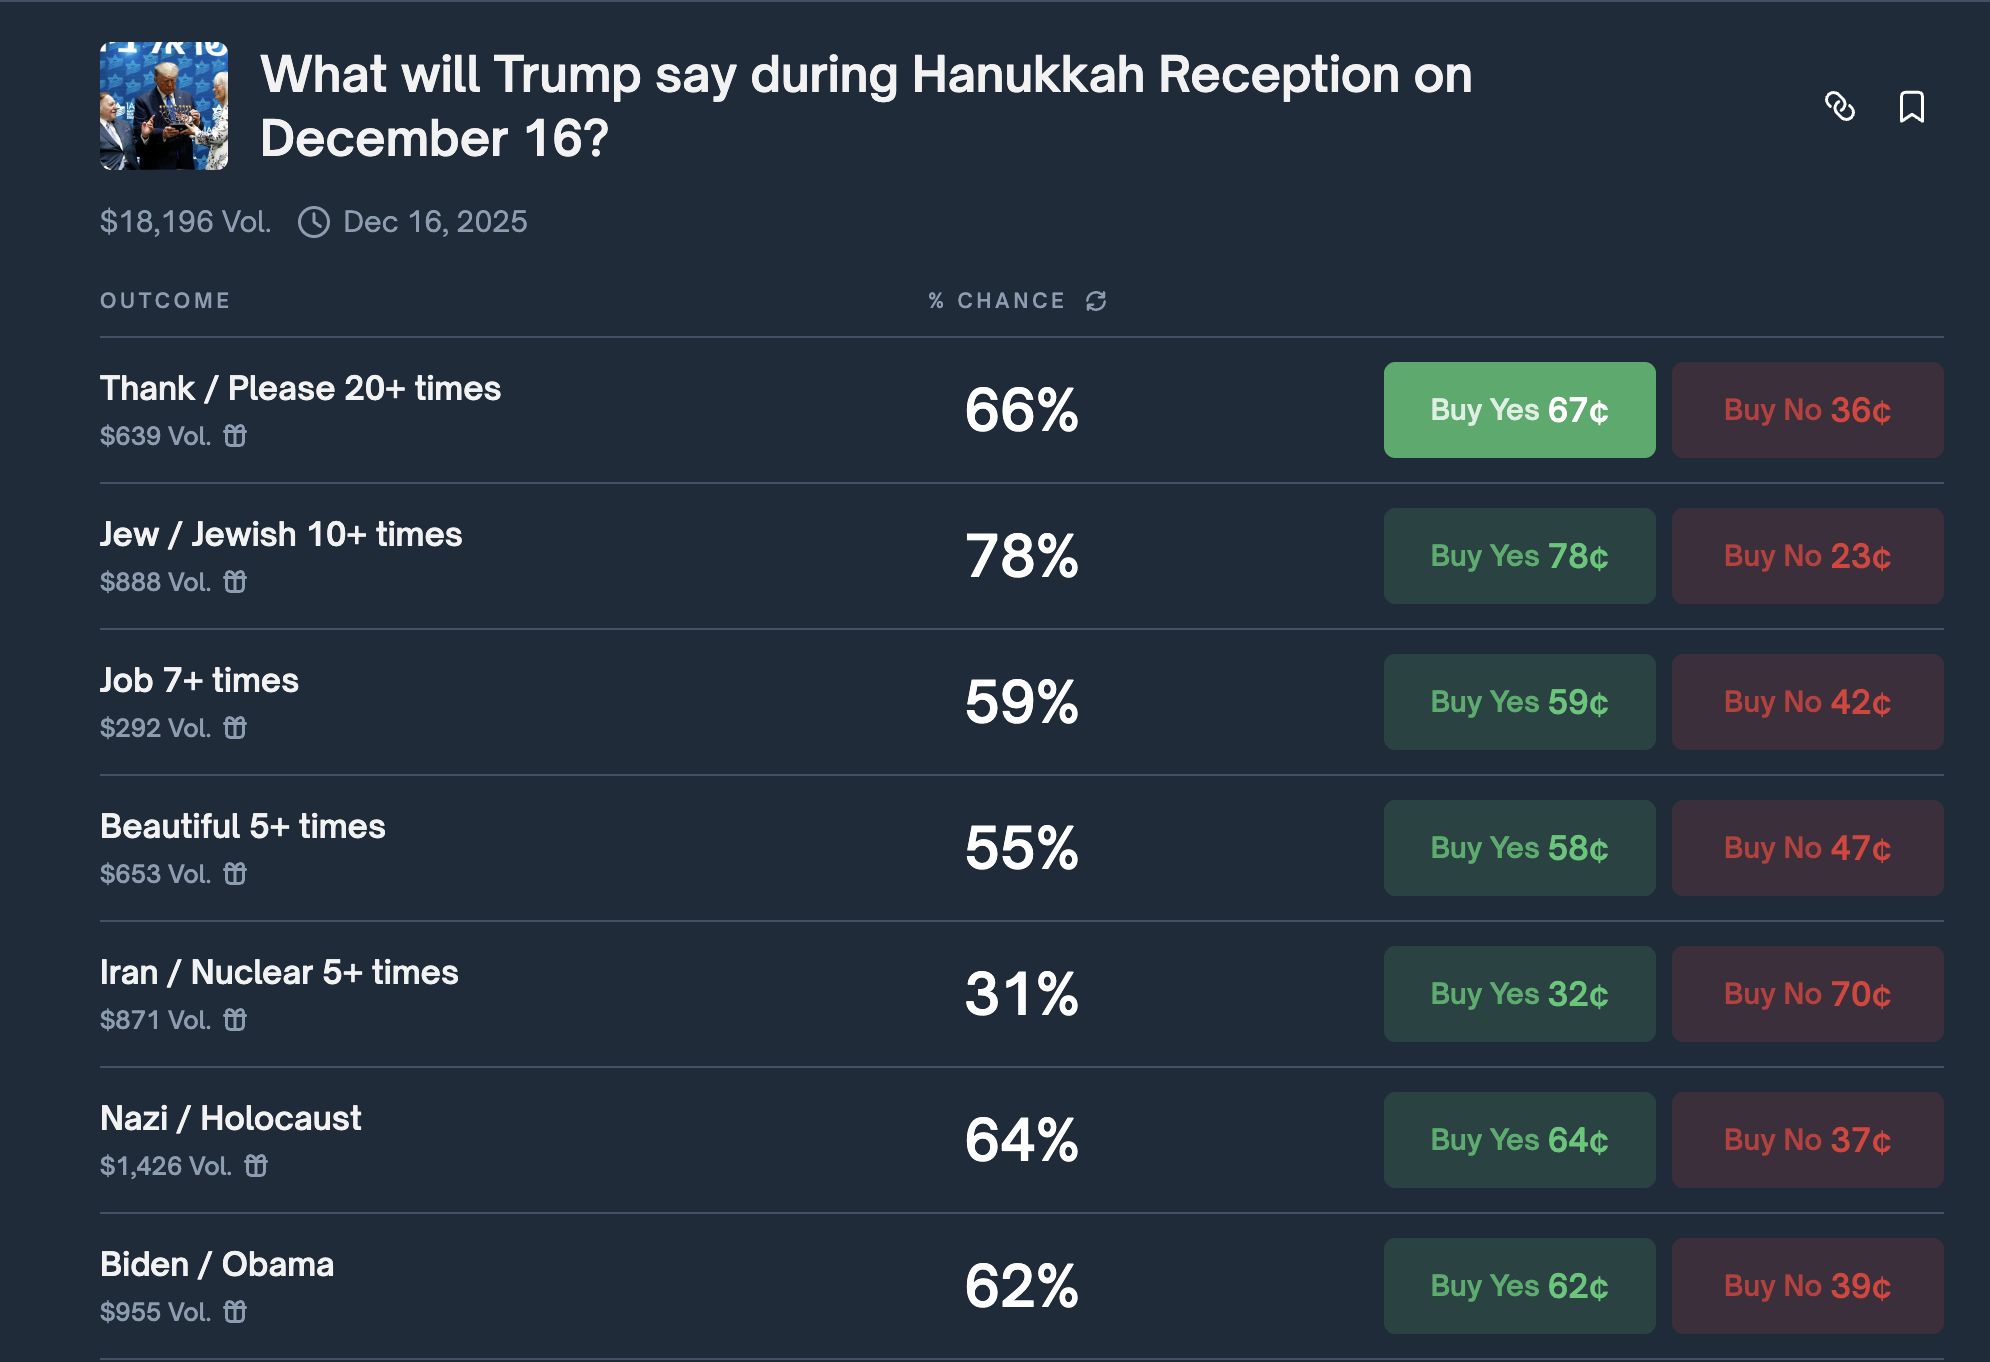

In [27]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Add src to path
project_root = Path.cwd().parent.parent
if str(project_root / "src") not in sys.path:
    sys.path.append(str(project_root / "src"))

from filtering_corpus.speech_corpus import SpeechCorpus

sns.set_theme(style="whitegrid")

## 1. Load Data

In [28]:
corpus = SpeechCorpus(data_dir=str(project_root / "data"), transcription_file="transcriptions.parquet")
df = corpus.get_full_speeches(text_columns=['clean_v1'])
df.rename(columns={'clean_v1': 'text'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Filter for speeches after 2014 (2015 onwards)
df = df[df['date'].dt.year > 2014].copy()

print(f"Total speeches loaded (Post-2014): {len(df)}")

Total speeches loaded (Post-2014): 853


## 2. Counting Logic

In [29]:
# Configuration for targets
TARGETS = {
    "please_thank": {
        "keywords": ["please", "thank", "thanks"],
        "threshold": 20,
        "label": "Please/Thank"
    },
    "jew_jewish": {
        "keywords": ["jew", "jewish", "jews"],
        "threshold": 10,
        "label": "Jew/Jewish"
    },
    "job": {
        "keywords": ["job", "jobs"],
        "threshold": 7,
        "label": "Job/Jobs"
    },
    "biden_obama": {
        "keywords": ["biden", "obama", "joe", "barack"],
        "threshold": 0, # Just interested in distribution
        "label": "Biden/Obama"
    }
}

def count_word_group(text, keywords):
    if not isinstance(text, str):
        return 0
    text_lower = text.lower()
    tokens = text_lower.split()
    count = 0
    for kw in keywords:
        # Simple substring count is dangerous for short words like 'job' (e.g. inside 'jobless' or 'applejob'?? unlikely but still)
        # Using token matching for accuracy where possible, or space-padded regex.
        # The cleaned text usually has no punctuation, so tokenizing by split is reasonable.
        count += tokens.count(kw)
    return count

# Apply counting
for key, config in TARGETS.items():
    col_name = f"count_{key}"
    df[col_name] = df['text'].apply(lambda x: count_word_group(x, config['keywords']))

print(df[['date', 'title'] + [f"count_{k}" for k in TARGETS.keys()]].head())

        date                                              title  \
0 2025-10-05  Speech: Donald Trump Addresses Service Members...   
1 2025-09-30  Speech: Donald Trump Addresses Military Leader...   
2 2025-09-23  Speech: Donald Trump Addresses the 80th Sessio...   
3 2025-09-21  Speech: Donald Trump Addresses a Memorial for ...   
4 2025-09-20  Speech: Donald Trump Addresses the American Co...   

   count_please_thank  count_jew_jewish  count_job  count_biden_obama  
0                  48                 0         10                  2  
1                   9                 0         19                 13  
2                  12                 0          8                  9  
3                   9                 1          1                  2  
4                  29                 0         10                  7  


## 3. Analysis Function

In [30]:
def analyze_target(df_subset, target_key, subset_label):
    col_name = f"count_{target_key}"
    config = TARGETS[target_key]
    threshold = config['threshold']
    
    if len(df_subset) == 0:
        return None
    
    stats = df_subset[col_name].describe()
    prob_threshold = (df_subset[col_name] >= threshold).mean()
    
    return {
        "Target": config['label'],
        "Subset": subset_label,
        "Count": len(df_subset),
        "Mean": stats['mean'],
        "Median": stats['50%'],
        "Max": stats['max'],
        f"Prob >={threshold}": prob_threshold
    }

## 4. Define Subsets

In [31]:
max_year = df['date'].dt.year.max()
ceremony_keywords = ['ceremony', 'religious', 'faith', 'dinner', 'summit', 'conference', 'reception', 'prayer', 'holiday', 'christmas', 'hanukkah']
pattern_ceremony = '|'.join(ceremony_keywords)

subsets = {
    "All (Post-2014)": df,
    "December": df[df['date'].dt.month == 12],
    "Last 3 Years": df[df['date'].dt.year >= (max_year - 2)],
    "Non-Rally": df[df['is_rally'] == False],
    "Ceremonies/Religious": df[df['title'].str.contains(pattern_ceremony, case=False, na=False)],
    "Dec + Non-Rally + Ceremony": df[(df['date'].dt.month == 12) & (df['is_rally'] == False) & (df['title'].str.contains(pattern_ceremony, case=False, na=False))]
}

results = []
for sub_name, sub_df in subsets.items():
    for target in TARGETS.keys():
        res = analyze_target(sub_df, target, sub_name)
        if res:
            results.append(res)

results_df = pd.DataFrame(results)
# Display results nicely grouped by Target
for target in TARGETS.keys():
    print(f"\n--- {TARGETS[target]['label']} ---")
    display_df = results_df[results_df['Target'] == TARGETS[target]['label']]
    # Use to_string to avoid tabulate dependency issues
    print(display_df.drop(columns=['Target']).to_string(index=False, float_format="%.2f"))


--- Please/Thank ---
                    Subset  Count  Mean  Median   Max  Prob >=20  Prob >=10  Prob >=7  Prob >=0
           All (Post-2014)    853 22.17   20.00 86.00       0.51        NaN       NaN       NaN
                  December     27 22.52   21.00 55.00       0.56        NaN       NaN       NaN
              Last 3 Years    221 31.21   29.00 78.00       0.81        NaN       NaN       NaN
                 Non-Rally    478 18.59   15.00 86.00       0.35        NaN       NaN       NaN
      Ceremonies/Religious     56 26.82   27.00 47.00       0.70        NaN       NaN       NaN
Dec + Non-Rally + Ceremony      3 36.67   41.00 43.00       1.00        NaN       NaN       NaN

--- Jew/Jewish ---
                    Subset  Count  Mean  Median   Max  Prob >=20  Prob >=10  Prob >=7  Prob >=0
           All (Post-2014)    853  0.29    0.00 42.00        NaN       0.01       NaN       NaN
                  December     27  0.56    0.00 11.00        NaN       0.04       NaN       Na

## 5. Visualizations

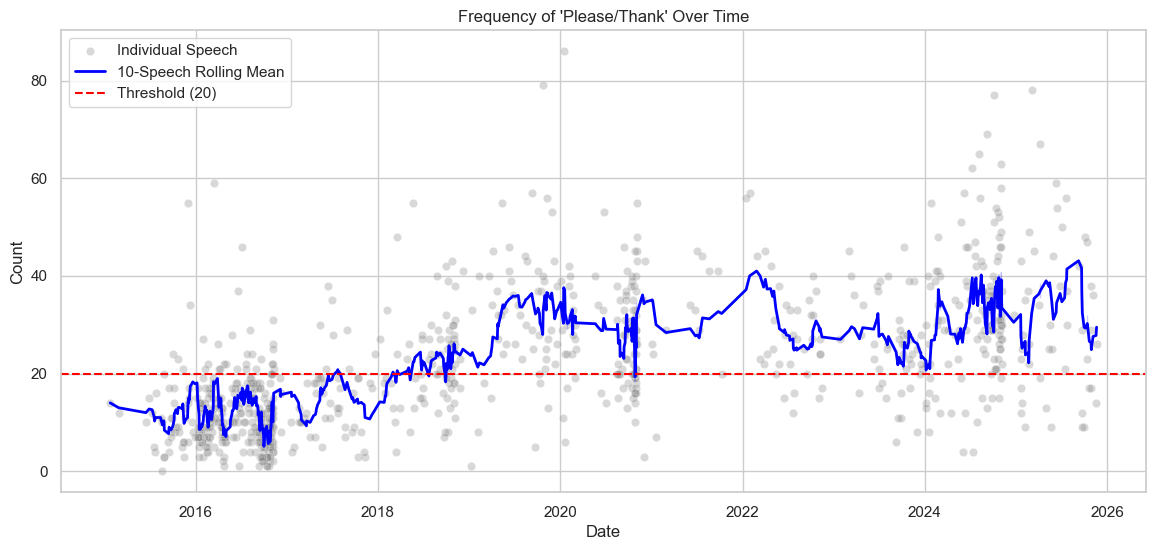

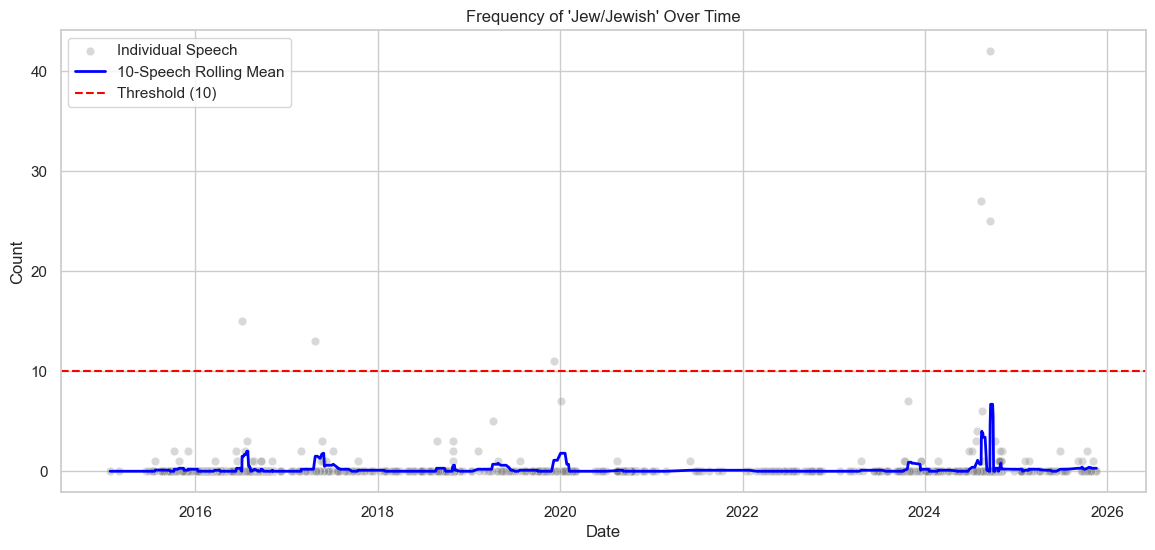

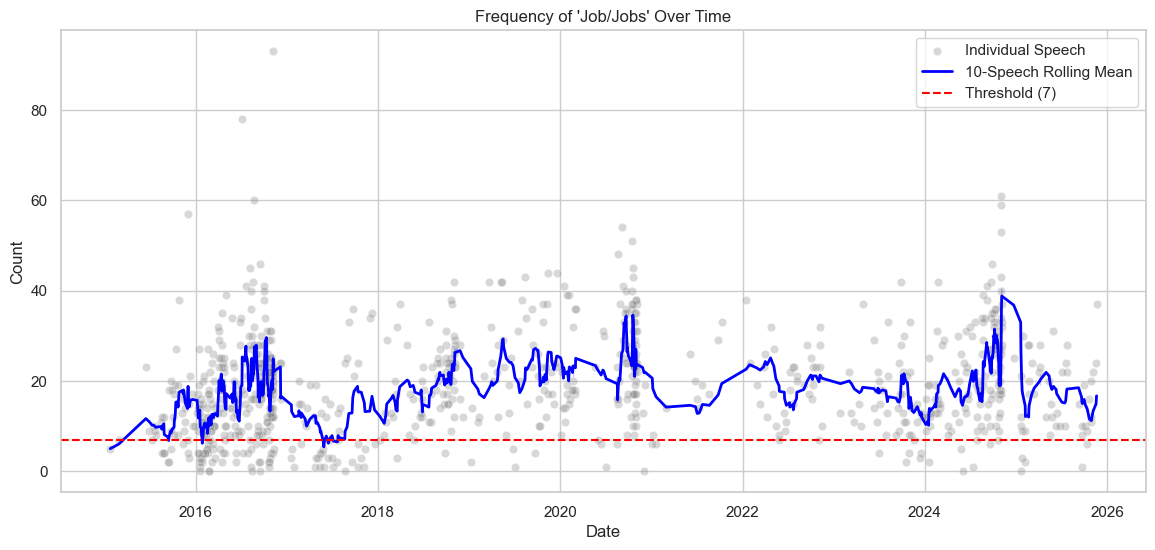

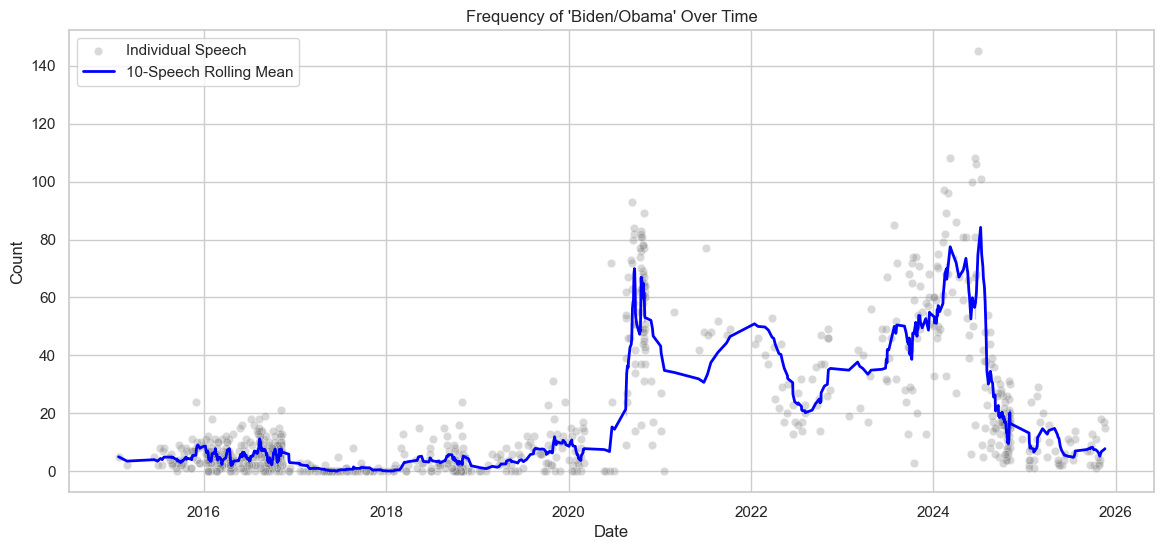

In [32]:
def plot_time_series(df, target_key, rolling_window=10):
    col_name = f"count_{target_key}"
    config = TARGETS[target_key]
    
    plt.figure(figsize=(14, 6))
    
    # Scatter of individual speeches
    # subset where count > 0 to reduce noise or keep all?
    # enhanced visibility: use alpha
    sns.scatterplot(data=df, x='date', y=col_name, alpha=0.3, color='gray', label='Individual Speech')
    
    # Rolling average trend
    df_sorted = df.sort_values('date')
    df_sorted['rolling_mean'] = df_sorted[col_name].rolling(window=rolling_window, min_periods=1).mean()
    
    sns.lineplot(data=df_sorted, x='date', y='rolling_mean', color='blue', linewidth=2, label=f'{rolling_window}-Speech Rolling Mean')
    
    # Threshold line
    if config['threshold'] > 0:
        plt.axhline(y=config['threshold'], color='red', linestyle='--', label=f"Threshold ({config['threshold']})")
    
    plt.title(f"Frequency of '{config['label']}' Over Time")
    plt.ylabel("Count")
    plt.xlabel("Date")
    plt.legend()
    plt.show()

# Generate plots for all targets
for target in TARGETS.keys():
    plot_time_series(df, target)

## 6. Distribution Boxplots per Subset

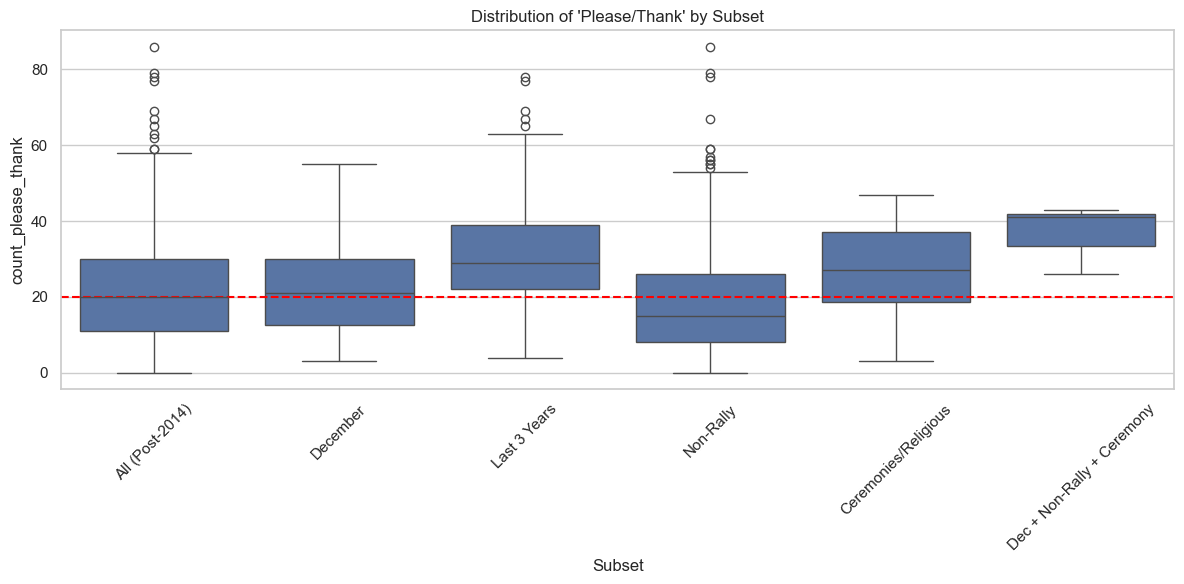

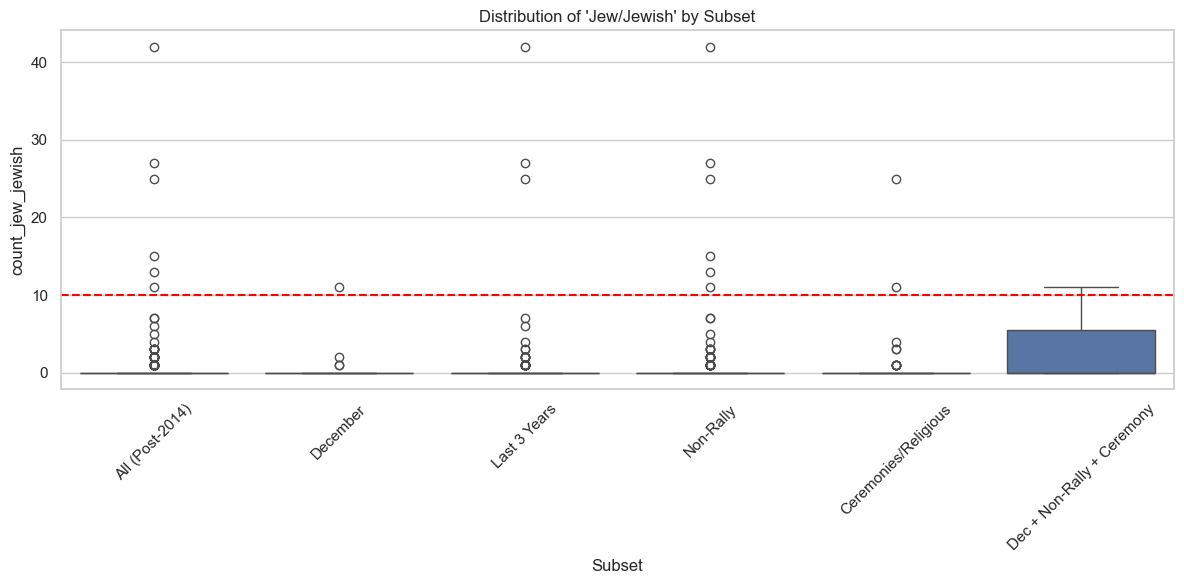

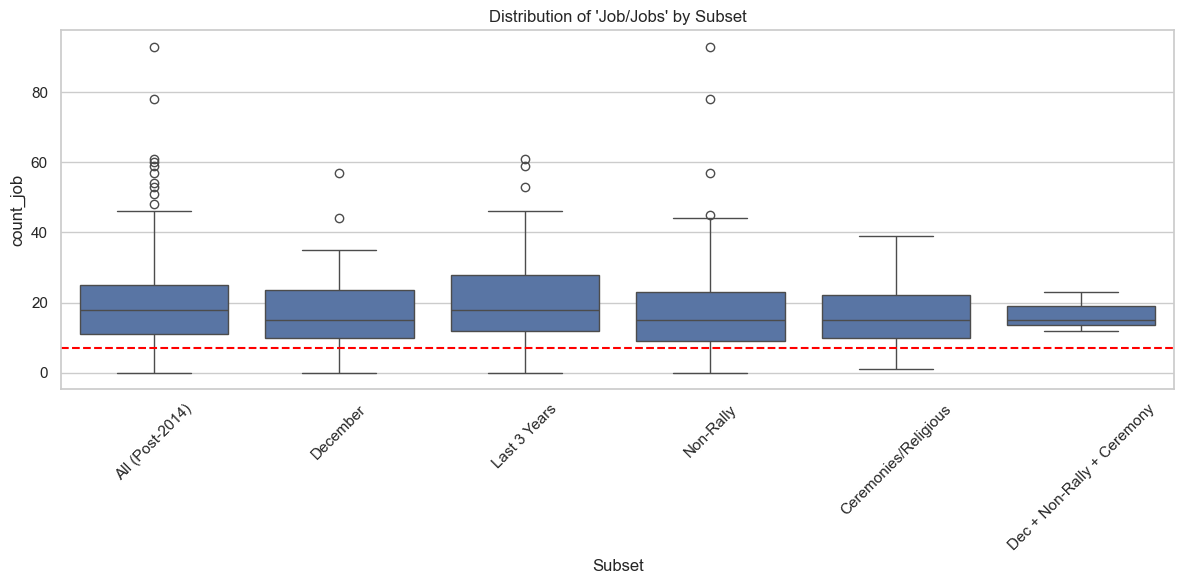

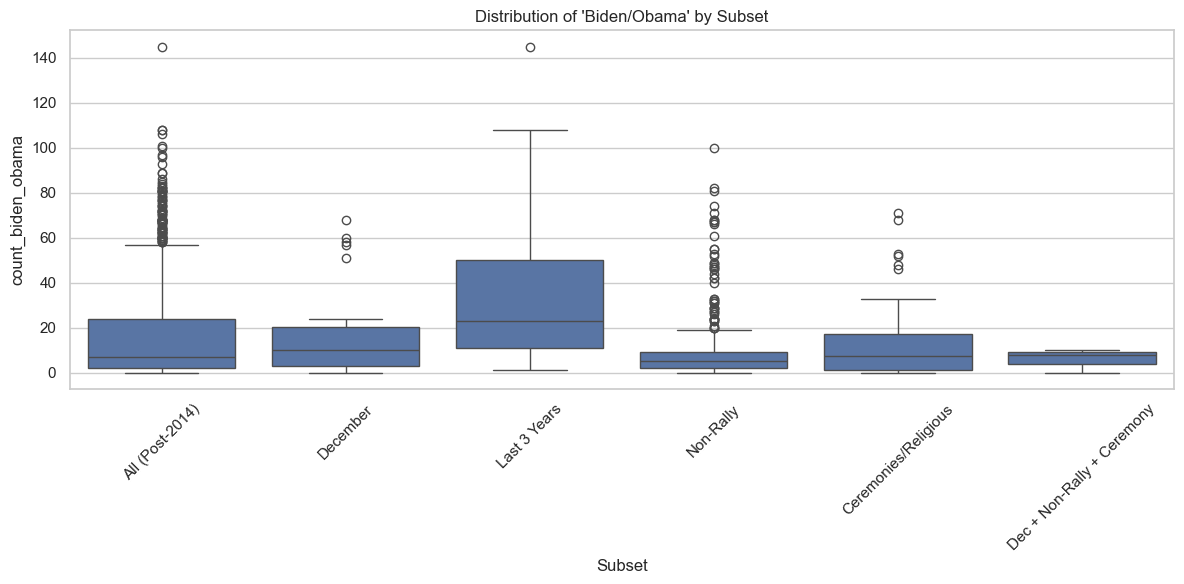

In [7]:
def plot_boxplots(target_key):
    col_name = f"count_{target_key}"
    config = TARGETS[target_key]
    
    # Prepare data in long format for nice plotting
    plot_data = []
    for sub_name, sub_df in subsets.items():
        temp = sub_df[[col_name]].copy()
        temp['Subset'] = sub_name
        plot_data.append(temp)
    
    if not plot_data:
        return
        
    long_df = pd.concat(plot_data)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=long_df, x='Subset', y=col_name)
    
    if config['threshold'] > 0:
        plt.axhline(y=config['threshold'], color='red', linestyle='--', label=f"Threshold ({config['threshold']})")
        
    plt.title(f"Distribution of '{config['label']}' by Subset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for target in TARGETS.keys():
    plot_boxplots(target)